# Grid Search SARIMA

In [117]:
%config IPCompleter.greedy=True
%matplotlib inline  

import pandas as pd
import numpy as np
from numpy import array
import datetime
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import itertools

from dataset.data import deutsches_wetter_dienst
from scripts.grid import grid_search

## Load Official Weather Data Observations

readings every hour

In [30]:
df = deutsches_wetter_dienst(2013, 2016, '/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt')
df.head()

,D_Temp,D_Humi
datetime,,
2013-01-01 00:00:00,8.4,70.0
2013-01-01 01:00:00,8.4,70.0
2013-01-01 02:00:00,8.4,69.0
2013-01-01 03:00:00,8.7,68.0
2013-01-01 04:00:00,8.5,69.0


In [31]:
# compute daily average : fill in nans created during resampling with the nearest value
timestep = 'D'
df = df.resample(timestep).nearest()
df.head()

,D_Temp,D_Humi
datetime,,
2013-01-01,8.4,70.0
2013-01-02,3.9,85.0
2013-01-03,5.9,78.0
2013-01-04,8.8,90.0
2013-01-05,8.6,94.0


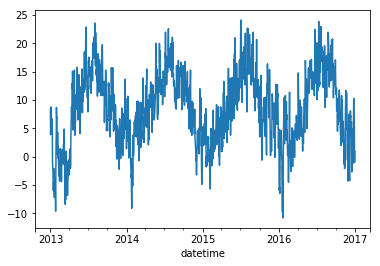

In [32]:
df.D_Temp.plot()

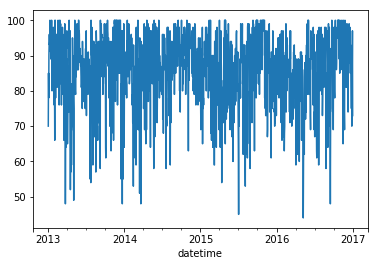

In [33]:
df.D_Humi.plot()

In [34]:
# select single variable for building model
sensor = 'D_Temp'
data = np.array(df[sensor])
len(data)

1461

## SARIMA Hyperparameters and Parsimony Principle
This model has hyperparameters that control the nature of the model performed for the series, trend and seasonality, specifically:

* order: A tuple p, d, and q parameters for the modeling of the trend.
* sesonal_order: A tuple of P, D, Q, and m parameters for the modeling the seasonality
* trend: A parameter for controlling a model of the deterministic trend as one of:
    * ‘n’ : no trend
    * ’c’: constant  
    * ’t’: linear 
    * ’ct’: constant with linear trend  


Best Practice:

https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima


Grid Search:

Grid search is used to help us select hyperparameters. In a grid search, we train and evaluate a model on all possible configurations of the hyperparameters. 

We can also overfitting by not building overly complex models, A simple rule of thumb for SARIMA is the Parsimony Principle in which  sum of hyperparameter values: p+d+q+P+D+Q ≤ 6.

The grid search we use constrains the value of each hyperparameter to satisfy the Parsimony Principle.

Cons: take a while depending on computing resources


In [130]:
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p = [0, 1]
    d = [0]
    q = [0, 1]
    t = ['c']
    P = [0, 1]
    D = [0]
    Q = [0, 1]
    m = seasonal
    
    non_seasonal = itertools.product(p, d, q)
    seasonal = itertools.product(P, D, Q, m)
    result = []
    for tup in itertools.product(non_seasonal, seasonal, t):
        result.append(list(tup))
    return result           

In [131]:
configs = sarima_configs()
print(len(configs))

16


## Subset data for training and validation

In [135]:
minidx = df.index.get_loc('2013-01-01')
maxidx = df.index.get_loc('2014-01-15')
n_validation = 20

In [133]:
trainval = data[minidx:maxidx] 
print(trainval)

[ 8.4  3.9  5.9  8.8  8.6  6.2  5.8  6.7  6.5  5.1 -0.5 -1.9 -2.2 -4.2
 -6.  -4.7 -4.3 -2.1 -5.5 -7.2 -3.9 -6.4 -6.5 -4.7 -7.7 -9.6 -2.5  2.4
  3.7  8.7  6.9  7.   0.8  0.4  4.1  4.3 -0.2  1.9 -0.3 -1.2 -2.2 -3.4
 -1.3 -3.2 -4.3 -2.8  1.2  1.4  0.6  1.4 -0.9 -2.1 -3.  -4.4 -1.5  0.4
  0.9  0.3  0.3  1.2 -0.7  1.3 -1.3  2.2 -0.1  4.4  4.9  0.   0.4 -4.8
 -4.5 -8.4 -2.1 -7.6 -4.8  1.   0.6 -1.5 -0.8 -1.6 -1.6 -3.2 -6.8 -4.4
 -4.  -3.2 -2.2 -0.6 -0.8 -2.5 -3.  -3.2  0.7  0.6  1.3  1.4 -2.  -1.2
  3.   4.7  5.8  8.8  8.6  6.6 12.9 12.  15.1 14.4  9.4  4.7  4.8 10.3
  6.3 10.6 14.3 15.3  6.4  3.8  8.7  6.7  6.1 10.7 10.9  8.4  9.2 10.
 11.3 13.6 15.8 12.6 11.2 10.8  6.5  9.2 10.3 13.3 14.5 12.9  6.7 10.2
 10.7 11.3  4.1  5.1  7.4  7.6  9.7  8.8 12.4 10.2 13.2 15.5  9.8  8.2
  7.8 11.5  9.8 11.3 13.3 12.4 13.7 13.2 11.4 18.5 11.8 12.3 12.7 14.9
 17.2 19.6 22.9 20.2 16.3 16.9 13.8 13.5 11.  10.4 10.4 12.5  7.9 14.3
 14.3 17.4 17.5 17.6 14.2 14.5 15.4 15.9 15.6 12.4 11.9 13.4 13.8 11.2
 14.2 1

In [136]:
# grid search
scores = grid_search(trainval, configs, n_validation)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 3.595
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'c']] 2.941
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'c']] 3.557
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'c']] 2.942
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'c']] 3.446
 > Model[[(0, 0, 1), (0, 0, 1, 0), 'c']] 3.091
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'c']] 3.557
 > Model[[(0, 0, 1), (1, 0, 0, 0), 'c']] 3.446
 > Model[[(1, 0, 0), (0, 0, 1, 0), 'c']] 3.446
 > Model[[(1, 0, 0), (1, 0, 0, 0), 'c']] 3.507
 > Model[[(0, 0, 1), (1, 0, 1, 0), 'c']] 3.196
 > Model[[(1, 0, 1), (0, 0, 0, 0), 'c']] 3.446
 > Model[[(1, 0, 1), (0, 0, 1, 0), 'c']] 3.196
 > Model[[(1, 0, 0), (1, 0, 1, 0), 'c']] 3.244
 > Model[[(1, 0, 1), (1, 0, 0, 0), 'c']] 3.244
 > Model[[(1, 0, 1), (1, 0, 1, 0), 'c']] 3.249
done
[(0, 0, 0), (0, 0, 1, 0), 'c'] 2.941331045374385
[(0, 0, 1), (0, 0, 0, 0), 'c'] 2.941626357120193
[(0, 0, 1), (0, 0, 1, 0), 'c'] 3.0909802541644824


## Split data into sequences 

In [215]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

## Build Train and Test Set
Define input sequence and choose a number of time steps

In [216]:
n_steps = 3
# split into samples
X, y = split_sequence(X, n_steps)

In [217]:
# look at what the splits
print('Number observations {}'.format(len(X)))
for i in range(20):
    print(X[i], y[i])

Number observations 727
[8.4 3.9 5.9] 8.8
[3.9 5.9 8.8] 8.6
[5.9 8.8 8.6] 6.2
[8.8 8.6 6.2] 5.8
[8.6 6.2 5.8] 6.7
[6.2 5.8 6.7] 6.5
[5.8 6.7 6.5] 5.1
[6.7 6.5 5.1] -0.5
[ 6.5  5.1 -0.5] -1.9
[ 5.1 -0.5 -1.9] -2.2
[-0.5 -1.9 -2.2] -4.2
[-1.9 -2.2 -4.2] -6.0
[-2.2 -4.2 -6. ] -4.7
[-4.2 -6.  -4.7] -4.3
[-6.  -4.7 -4.3] -2.1
[-4.7 -4.3 -2.1] -5.5
[-4.3 -2.1 -5.5] -7.2
[-2.1 -5.5 -7.2] -3.9
[-5.5 -7.2 -3.9] -6.4
[-7.2 -3.9 -6.4] -6.5


In [260]:
## create a train and test set
xtrain  = X[0:364,:]
ytrain = y[0:364]

# evaluate model performance validation 
min_index =  365
max_index = 565
xval  = X[min_index:max_index,:]
yval = y[min_index:max_index]

#print('xval {}'.format(xval))
#print('yval {}'.format(yval))

validation_data = (xval, yval)
validation_data

(array([[ 1.4,  3.8,  6.4],
        [ 3.8,  6.4,  5.8],
        [ 6.4,  5.8,  2.8],
        [ 5.8,  2.8,  2.8],
        [ 2.8,  2.8, 10.7],
        [ 2.8, 10.7,  9.8],
        [10.7,  9.8,  5.7],
        [ 9.8,  5.7,  6.2],
        [ 5.7,  6.2,  4.3],
        [ 6.2,  4.3,  4.2],
        [ 4.3,  4.2, -0.2],
        [ 4.2, -0.2,  3.9],
        [-0.2,  3.9,  1. ],
        [ 3.9,  1. ,  2.3],
        [ 1. ,  2.3,  6.5],
        [ 2.3,  6.5,  4.8],
        [ 6.5,  4.8,  4.1],
        [ 4.8,  4.1,  0. ],
        [ 4.1,  0. , -1.7],
        [ 0. , -1.7, -1.8],
        [-1.7, -1.8, -3.7],
        [-1.8, -3.7, -3.2],
        [-3.7, -3.2, -6.3],
        [-3.2, -6.3, -9.1],
        [-6.3, -9.1, -4.9],
        [-9.1, -4.9, -0.3],
        [-4.9, -0.3, -1.3],
        [-0.3, -1.3, -4.7],
        [-1.3, -4.7, -5.1],
        [-4.7, -5.1, -1.8],
        [-5.1, -1.8,  3.8],
        [-1.8,  3.8,  0.1],
        [ 3.8,  0.1,  0.6],
        [ 0.1,  0.6,  1.2],
        [ 0.6,  1.2,  4.7],
        [ 1.2,  4.7,

## Train and test a model: 

TODO: Explain : relu, adam, mse, epoch, architecture?

First Results: Univariate MLP is not doing so badly; more epochs did not produce better results; running multiple times yields slightly difference results 

In [249]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
# fit model
history = model.fit(xtrain, ytrain, epochs=100, verbose=1)

Epoch 1/100
364/364 [==============================] - 0s 989us/step - loss: 5.0082
Epoch 2/100
364/364 [==============================] - 0s 95us/step - loss: 2.8747
Epoch 3/100
364/364 [==============================] - 0s 68us/step - loss: 2.5340
Epoch 4/100
364/364 [==============================] - 0s 70us/step - loss: 2.5047
Epoch 5/100
364/364 [==============================] - 0s 73us/step - loss: 2.3947
Epoch 6/100
364/364 [==============================] - 0s 68us/step - loss: 2.3605
Epoch 7/100
364/364 [==============================] - 0s 60us/step - loss: 2.3560
Epoch 8/100
364/364 [==============================] - 0s 73us/step - loss: 2.3215
Epoch 9/100
364/364 [==============================] - 0s 83us/step - loss: 2.3069
Epoch 10/100
364/364 [==============================] - 0s 55us/step - loss: 2.2977
Epoch 11/100
364/364 [==============================] - 0s 67us/step - loss: 2.2759
Epoch 12/100
364/364 [==============================] - 0s 61us/step - loss: 2.2649


In [253]:


x_input = xtest.reshape((1, n_steps))
ypredict = model.predict(x_input, verbose=1)
print(ypredict)

xval [[ 1.4  3.8  6.4]
 [ 3.8  6.4  5.8]
 [ 6.4  5.8  2.8]
 [ 5.8  2.8  2.8]
 [ 2.8  2.8 10.7]
 [ 2.8 10.7  9.8]
 [10.7  9.8  5.7]
 [ 9.8  5.7  6.2]
 [ 5.7  6.2  4.3]
 [ 6.2  4.3  4.2]
 [ 4.3  4.2 -0.2]
 [ 4.2 -0.2  3.9]
 [-0.2  3.9  1. ]
 [ 3.9  1.   2.3]
 [ 1.   2.3  6.5]
 [ 2.3  6.5  4.8]
 [ 6.5  4.8  4.1]
 [ 4.8  4.1  0. ]
 [ 4.1  0.  -1.7]
 [ 0.  -1.7 -1.8]
 [-1.7 -1.8 -3.7]
 [-1.8 -3.7 -3.2]
 [-3.7 -3.2 -6.3]
 [-3.2 -6.3 -9.1]
 [-6.3 -9.1 -4.9]
 [-9.1 -4.9 -0.3]
 [-4.9 -0.3 -1.3]
 [-0.3 -1.3 -4.7]
 [-1.3 -4.7 -5.1]
 [-4.7 -5.1 -1.8]
 [-5.1 -1.8  3.8]
 [-1.8  3.8  0.1]
 [ 3.8  0.1  0.6]
 [ 0.1  0.6  1.2]
 [ 0.6  1.2  4.7]
 [ 1.2  4.7  6. ]
 [ 4.7  6.   5.8]
 [ 6.   5.8  6.4]
 [ 5.8  6.4  4.2]
 [ 6.4  4.2  3.7]
 [ 4.2  3.7  5.2]
 [ 3.7  5.2  7.2]
 [ 5.2  7.2  3.6]
 [ 7.2  3.6  6.1]
 [ 3.6  6.1  7.9]
 [ 6.1  7.9  3.9]
 [ 7.9  3.9  4.7]
 [ 3.9  4.7  4.2]
 [ 4.7  4.2  6. ]
 [ 4.2  6.   9.8]
 [ 6.   9.8  3.4]
 [ 9.8  3.4  4.2]
 [ 3.4  4.2  2.2]
 [ 4.2  2.2  2.7]
 [ 2.2  2.7  9.8]
 [ 2.

ValueError: cannot reshape array of size 600 into shape (1,3)

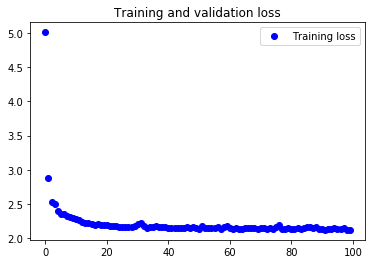

In [250]:
import matplotlib.pyplot as plt

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Conversation Cafe:

How far into the future can predict with current model  
How good is a model for humidity
Do we can better prediction if we use 2 years of data?
What else could we predict besides temperature?
Do we get better results if we normalize the data before training?
How good is our model?